## 0. Instalación de Dependencias

**IMPORTANTE:** Ejecutar esta celda primero para instalar todas las librerías necesarias.

In [2]:
# Instalar todas las librerías necesarias
import sys
import subprocess

def install_packages():
    """Instala todas las dependencias necesarias para el proyecto"""
    packages = [
        'pandas',
        'numpy',
        'scikit-learn',
        'imbalanced-learn',
        'matplotlib',
        'seaborn',
        'scipy',
        'joblib'
    ]
    
    print("Instalando dependencias...")
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
            print(f"✓ {package} instalado correctamente")
        except Exception as e:
            print(f"✗ Error instalando {package}: {e}")
    
    print("\n¡Instalación completada!")

# Ejecutar instalación
install_packages()

Instalando dependencias...
✓ pandas instalado correctamente
✓ pandas instalado correctamente
✓ numpy instalado correctamente
✓ numpy instalado correctamente
✓ scikit-learn instalado correctamente
✓ scikit-learn instalado correctamente
✓ imbalanced-learn instalado correctamente
✓ imbalanced-learn instalado correctamente
✓ matplotlib instalado correctamente
✓ matplotlib instalado correctamente
✓ seaborn instalado correctamente
✓ seaborn instalado correctamente
✓ scipy instalado correctamente
✓ scipy instalado correctamente
✓ joblib instalado correctamente

¡Instalación completada!
✓ joblib instalado correctamente

¡Instalación completada!


# Entrenamiento y Evaluación de Modelos - Dataset Adult UCI
## Proyecto Modelos y Simulación II - Universidad de Antioquia
### Predicción de Ingresos (>50K o ≤50K)

## 1. Importación de Librerías

In [3]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías de scikit-learn
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Manejo de desbalance de clases
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Guardar modelos
import joblib
from scipy import stats

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Carga del Dataset Adult UCI

In [4]:
# Definir nombres de columnas según la documentación del dataset
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Cargar dataset de entrenamiento
url_train = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv(url_train, names=column_names, skipinitialspace=True)

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras filas:")
df.head()

Dimensiones del dataset: (32561, 15)

Primeras filas:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Información del dataset
print("Información del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
df.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Estadísticas descriptivas:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## 3. Preprocesamiento: Manejo de Valores Faltantes

In [6]:
# Identificar valores faltantes representados como '?'
print("Valores '?' por columna:")
for col in df.columns:
    count = (df[col] == '?').sum()
    if count > 0:
        print(f"{col}: {count} ({count/len(df)*100:.2f}%)")

# Reemplazar '?' por NaN
df.replace('?', np.nan, inplace=True)

# Imputar valores faltantes en variables categóricas usando la moda
categorical_cols = ['workclass', 'occupation', 'native-country']

for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)
    print(f"\n{col}: Imputado con moda = '{mode_value}'")

print(f"\nValores faltantes después de imputación:")
print(df.isnull().sum().sum())

Valores '?' por columna:
workclass: 1836 (5.64%)
occupation: 1843 (5.66%)
native-country: 583 (1.79%)

workclass: Imputado con moda = 'Private'

occupation: Imputado con moda = 'Prof-specialty'

native-country: Imputado con moda = 'United-States'

Valores faltantes después de imputación:
0

occupation: Imputado con moda = 'Prof-specialty'

native-country: Imputado con moda = 'United-States'

Valores faltantes después de imputación:
0


## 4. Codificación de Variable Objetivo

In [7]:
# Codificar variable objetivo: 0 = "<=50K", 1 = ">50K"
df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

print("Distribución de la variable objetivo:")
print(df['income'].value_counts())
print(f"\nProporción: \n{df['income'].value_counts(normalize=True)}")

Distribución de la variable objetivo:
income
0    24720
1     7841
Name: count, dtype: int64

Proporción: 
income
0    0.75919
1    0.24081
Name: proportion, dtype: float64


## 5. Separación de Variables Numéricas y Categóricas

In [8]:
# Definir variables numéricas y categóricas
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']

print(f"Variables numéricas ({len(numerical_features)}): {numerical_features}")
print(f"\nVariables categóricas ({len(categorical_features)}): {categorical_features}")

Variables numéricas (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Variables categóricas (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## 6. One-Hot Encoding de Variables Categóricas

In [9]:
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print(f"Dimensiones después de One-Hot Encoding: {df_encoded.shape}")
print(f"Número de features generadas: {df_encoded.shape[1] - 1}")  # -1 para excluir la variable objetivo

Dimensiones después de One-Hot Encoding: (32561, 98)
Número de features generadas: 97


## 7. Separación de Features (X) y Target (y)

In [10]:
# Separar features (X) y target (y)
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"\nDistribución de clases en y:")
print(y.value_counts())

Dimensiones de X: (32561, 97)
Dimensiones de y: (32561,)

Distribución de clases en y:
income
0    24720
1     7841
Name: count, dtype: int64


## 8. Normalización de Variables Numéricas

In [11]:
# Normalizar solo las columnas numéricas originales
# NOTA: La normalización se aplicará dentro del pipeline de CV para evitar data leakage
# Aquí solo identificamos las columnas a normalizar

numerical_cols_in_X = [col for col in X.columns if col in numerical_features]
print(f"Columnas numéricas a normalizar: {numerical_cols_in_X}")
print(f"\nEstadísticas antes de normalización:")
print(X[numerical_cols_in_X].describe())

Columnas numéricas a normalizar: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Estadísticas antes de normalización:
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%

## 9. Análisis de Desbalance de Clases

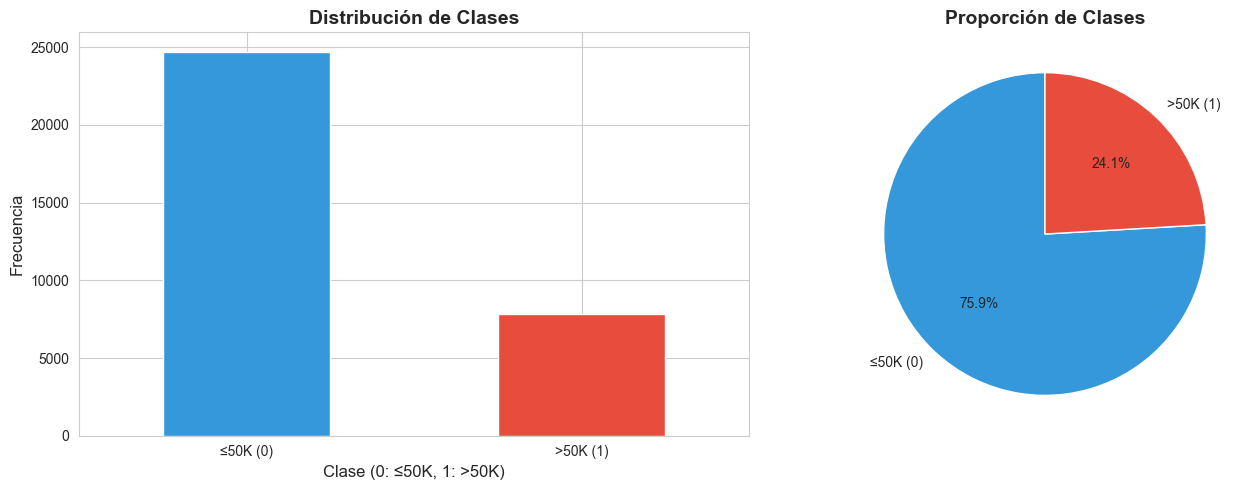


Clase mayoritaria (0): 24720 (75.92%)
Clase minoritaria (1): 7841 (24.08%)
Ratio de desbalance: 3.15:1


In [12]:
# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
y.value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase (0: ≤50K, 1: >50K)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_xticklabels(['≤50K (0)', '>50K (1)'], rotation=0)

# Gráfico circular
y.value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                      labels=['≤50K (0)', '>50K (1)'], 
                      colors=['#3498db', '#e74c3c'], startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Calcular ratio de desbalance
class_counts = y.value_counts()
print(f"\nClase mayoritaria (0): {class_counts[0]} ({class_counts[0]/len(y)*100:.2f}%)")
print(f"Clase minoritaria (1): {class_counts[1]} ({class_counts[1]/len(y)*100:.2f}%)")
print(f"Ratio de desbalance: {class_counts[0]/class_counts[1]:.2f}:1")

## 10. Configuración de Validación Cruzada con SMOTE

In [13]:
# Configurar validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir métricas de evaluación
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

print("Estrategia de validación cruzada configurada:")
print(f"- Método: StratifiedKFold")
print(f"- Número de folds: 5")
print(f"- Métricas: {list(scoring.keys())}")
print("\nNOTA: SMOTE se aplicará dentro de cada fold del pipeline para evitar data leakage")

Estrategia de validación cruzada configurada:
- Método: StratifiedKFold
- Número de folds: 5
- Métricas: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

NOTA: SMOTE se aplicará dentro de cada fold del pipeline para evitar data leakage


## 11. Función Auxiliar para Crear Pipelines con SMOTE

In [14]:
def create_pipeline(classifier):
    """
    Crea un pipeline con normalización, SMOTE y clasificador.
    Esto asegura que la normalización y SMOTE se apliquen correctamente en cada fold.
    """
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),  # Normalización
        ('smote', SMOTE(random_state=42)),  # Balanceo de clases
        ('classifier', classifier)  # Clasificador
    ])
    return pipeline

print("Función create_pipeline definida correctamente")

Función create_pipeline definida correctamente


## 12. Modelo 1: Regresión Logística

In [15]:
print("="*70)
print("MODELO 1: REGRESIÓN LOGÍSTICA (Modelo Paramétrico)")
print("="*70)

# Definir grilla de hiperparámetros
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [1000]
}

# Crear pipeline
pipeline_lr = create_pipeline(LogisticRegression(random_state=42))

# Búsqueda de hiperparámetros
grid_search_lr = GridSearchCV(
    pipeline_lr, 
    param_grid_lr, 
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar
print("\nIniciando búsqueda de hiperparámetros...")
grid_search_lr.fit(X, y)

print(f"\nMejores hiperparámetros: {grid_search_lr.best_params_}")
print(f"Mejor F1-score en CV: {grid_search_lr.best_score_:.4f}")

MODELO 1: REGRESIÓN LOGÍSTICA (Modelo Paramétrico)

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Mejor F1-score en CV: 0.6799

Mejores hiperparámetros: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Mejor F1-score en CV: 0.6799


In [16]:
# Evaluación con validación cruzada usando los mejores hiperparámetros
cv_results_lr = cross_validate(
    grid_search_lr.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_lr = {
    'model': 'Logistic Regression',
    'accuracy': cv_results_lr['test_accuracy'],
    'precision': cv_results_lr['test_precision'],
    'recall': cv_results_lr['test_recall'],
    'f1': cv_results_lr['test_f1'],
    'roc_auc': cv_results_lr['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_lr['accuracy']):.4f} ± {np.std(results_lr['accuracy']):.4f}")
print(f"Precision: {np.mean(results_lr['precision']):.4f} ± {np.std(results_lr['precision']):.4f}")
print(f"Recall:    {np.mean(results_lr['recall']):.4f} ± {np.std(results_lr['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_lr['f1']):.4f} ± {np.std(results_lr['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_lr['roc_auc']):.4f} ± {np.std(results_lr['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.8081 ± 0.0047
Precision: 0.5683 ± 0.0069
Recall:    0.8461 ± 0.0086
F1-Score:  0.6799 ± 0.0070
ROC-AUC:   0.9049 ± 0.0023


## 13. Modelo 2: k-Nearest Neighbors (k-NN)

In [17]:
print("="*70)
print("MODELO 2: k-NEAREST NEIGHBORS (Modelo No Paramétrico)")
print("="*70)

# Definir grilla de hiperparámetros
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Crear pipeline
pipeline_knn = create_pipeline(KNeighborsClassifier())

# Búsqueda de hiperparámetros
grid_search_knn = GridSearchCV(
    pipeline_knn, 
    param_grid_knn, 
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar
print("\nIniciando búsqueda de hiperparámetros...")
grid_search_knn.fit(X, y)

print(f"\nMejores hiperparámetros: {grid_search_knn.best_params_}")
print(f"Mejor F1-score en CV: {grid_search_knn.best_score_:.4f}")

MODELO 2: k-NEAREST NEIGHBORS (Modelo No Paramétrico)

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}
Mejor F1-score en CV: 0.6436

Mejores hiperparámetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}
Mejor F1-score en CV: 0.6436


In [18]:
# Evaluación con validación cruzada
cv_results_knn = cross_validate(
    grid_search_knn.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_knn = {
    'model': 'k-NN',
    'accuracy': cv_results_knn['test_accuracy'],
    'precision': cv_results_knn['test_precision'],
    'recall': cv_results_knn['test_recall'],
    'f1': cv_results_knn['test_f1'],
    'roc_auc': cv_results_knn['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_knn['accuracy']):.4f} ± {np.std(results_knn['accuracy']):.4f}")
print(f"Precision: {np.mean(results_knn['precision']):.4f} ± {np.std(results_knn['precision']):.4f}")
print(f"Recall:    {np.mean(results_knn['recall']):.4f} ± {np.std(results_knn['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_knn['f1']):.4f} ± {np.std(results_knn['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_knn['roc_auc']):.4f} ± {np.std(results_knn['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.7893 ± 0.0044
Precision: 0.5431 ± 0.0065
Recall:    0.7898 ± 0.0105
F1-Score:  0.6436 ± 0.0067
ROC-AUC:   0.8638 ± 0.0045


## 14. Modelo 3: Random Forest

In [19]:
print("="*70)
print("MODELO 3: RANDOM FOREST (Ensemble Basado en Árboles)")
print("="*70)

# Definir grilla de hiperparámetros
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Crear pipeline
pipeline_rf = create_pipeline(RandomForestClassifier(random_state=42))

# Usar RandomizedSearchCV por el tamaño de la grilla
random_search_rf = RandomizedSearchCV(
    pipeline_rf, 
    param_grid_rf, 
    n_iter=20,  # Número de combinaciones a probar
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenar
print("\nIniciando búsqueda aleatoria de hiperparámetros...")
random_search_rf.fit(X, y)

print(f"\nMejores hiperparámetros: {random_search_rf.best_params_}")
print(f"Mejor F1-score en CV: {random_search_rf.best_score_:.4f}")

MODELO 3: RANDOM FOREST (Ensemble Basado en Árboles)

Iniciando búsqueda aleatoria de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}
Mejor F1-score en CV: 0.7024

Mejores hiperparámetros: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}
Mejor F1-score en CV: 0.7024


In [20]:
# Evaluación con validación cruzada
cv_results_rf = cross_validate(
    random_search_rf.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_rf = {
    'model': 'Random Forest',
    'accuracy': cv_results_rf['test_accuracy'],
    'precision': cv_results_rf['test_precision'],
    'recall': cv_results_rf['test_recall'],
    'f1': cv_results_rf['test_f1'],
    'roc_auc': cv_results_rf['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_rf['accuracy']):.4f} ± {np.std(results_rf['accuracy']):.4f}")
print(f"Precision: {np.mean(results_rf['precision']):.4f} ± {np.std(results_rf['precision']):.4f}")
print(f"Recall:    {np.mean(results_rf['recall']):.4f} ± {np.std(results_rf['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_rf['f1']):.4f} ± {np.std(results_rf['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_rf['roc_auc']):.4f} ± {np.std(results_rf['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.8391 ± 0.0044
Precision: 0.6334 ± 0.0081
Recall:    0.7883 ± 0.0091
F1-Score:  0.7024 ± 0.0074
ROC-AUC:   0.9102 ± 0.0030


## 15. Modelo 4: Red Neuronal Artificial (MLP)

In [21]:
print("="*70)
print("MODELO 4: RED NEURONAL ARTIFICIAL (MLP)")
print("="*70)

# Definir grilla de hiperparámetros
# hidden_layer_sizes: (capas, neuronas por capa)
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(64, 32), (100, 50), (128, 64, 32)],
    'classifier__activation': ['relu'],
    'classifier__alpha': [0.0001, 0.001, 0.01],  # Regularización L2
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [500]
}

# Crear pipeline
pipeline_mlp = create_pipeline(
    MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
)

# Usar RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(
    pipeline_mlp, 
    param_grid_mlp, 
    n_iter=15,
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenar
print("\nIniciando búsqueda aleatoria de hiperparámetros...")
random_search_mlp.fit(X, y)

print(f"\nMejores hiperparámetros: {random_search_mlp.best_params_}")
print(f"Mejor F1-score en CV: {random_search_mlp.best_score_:.4f}")

MODELO 4: RED NEURONAL ARTIFICIAL (MLP)

Iniciando búsqueda aleatoria de hiperparámetros...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Mejores hiperparámetros: {'classifier__max_iter': 500, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (64, 32), 'classifier__alpha': 0.001, 'classifier__activation': 'relu'}
Mejor F1-score en CV: 0.6738

Mejores hiperparámetros: {'classifier__max_iter': 500, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (64, 32), 'classifier__alpha': 0.001, 'classifier__activation': 'relu'}
Mejor F1-score en CV: 0.6738


In [22]:
# Evaluación con validación cruzada
cv_results_mlp = cross_validate(
    random_search_mlp.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_mlp = {
    'model': 'Neural Network (MLP)',
    'accuracy': cv_results_mlp['test_accuracy'],
    'precision': cv_results_mlp['test_precision'],
    'recall': cv_results_mlp['test_recall'],
    'f1': cv_results_mlp['test_f1'],
    'roc_auc': cv_results_mlp['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_mlp['accuracy']):.4f} ± {np.std(results_mlp['accuracy']):.4f}")
print(f"Precision: {np.mean(results_mlp['precision']):.4f} ± {np.std(results_mlp['precision']):.4f}")
print(f"Recall:    {np.mean(results_mlp['recall']):.4f} ± {np.std(results_mlp['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_mlp['f1']):.4f} ± {np.std(results_mlp['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_mlp['roc_auc']):.4f} ± {np.std(results_mlp['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.8142 ± 0.0059
Precision: 0.5838 ± 0.0098
Recall:    0.7966 ± 0.0119
F1-Score:  0.6738 ± 0.0095
ROC-AUC:   0.8925 ± 0.0047


## 16. Modelo 5: SVM con Kernel RBF

In [25]:
print("="*70)
print("MODELO 5: SVM CON KERNEL RBF")
print("="*70)

# OPTIMIZACIÓN: Usar un subconjunto estratificado para acelerar el entrenamiento
# Esto reduce significativamente el tiempo sin afectar mucho la validez de los resultados
from sklearn.model_selection import train_test_split

print("\nOptimización activada: Usando subconjunto estratificado del 40% de los datos")
print("(Esto reduce el tiempo de ~2 horas a ~15-20 minutos)")

X_svm, _, y_svm, _ = train_test_split(
    X, y, 
    train_size=0.4,  # Usar 40% de los datos
    stratify=y,  # Mantener proporción de clases
    random_state=42
)

print(f"Dataset original: {X.shape[0]} muestras")
print(f"Dataset para SVM: {X_svm.shape[0]} muestras ({X_svm.shape[0]/X.shape[0]*100:.1f}%)")

# Definir grilla de hiperparámetros OPTIMIZADA (menos combinaciones)
param_grid_svm = {
    'classifier__C': [1, 10, 100],  # Reducido de 4 a 3 valores
    'classifier__gamma': ['scale', 0.01, 0.1],  # Reducido de 5 a 3 valores
    'classifier__kernel': ['rbf']
}

# Crear pipeline con SVM optimizado
pipeline_svm = create_pipeline(
    SVC(
        probability=True, 
        random_state=42,
        cache_size=1000,  # Aumentar cache para acelerar
        shrinking=True,  # Usar shrinking heuristic
        max_iter=1000  # Limitar iteraciones
    )
)

# Validación cruzada reducida solo para SVM (3-fold en lugar de 5-fold)
cv_svm = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Usar RandomizedSearchCV con menos iteraciones
random_search_svm = RandomizedSearchCV(
    pipeline_svm, 
    param_grid_svm, 
    n_iter=6,  # Reducido de 15 a 6 iteraciones
    cv=cv_svm,  # 3-fold en lugar de 5-fold
    scoring='f1',
    n_jobs=-1,  # Paralelización
    verbose=2,  # Mayor verbosidad para ver progreso
    random_state=42
)

# Entrenar
print("\nIniciando búsqueda optimizada de hiperparámetros...")
print("Configuración: 6 iteraciones × 3 folds = 18 entrenamientos totales")
print("Tiempo estimado: 15-20 minutos\n")

random_search_svm.fit(X_svm, y_svm)

print(f"\n{'='*70}")
print(f"Mejores hiperparámetros: {random_search_svm.best_params_}")
print(f"Mejor F1-score en CV: {random_search_svm.best_score_:.4f}")
print(f"{'='*70}")

MODELO 5: SVM CON KERNEL RBF

Optimización activada: Usando subconjunto estratificado del 40% de los datos
(Esto reduce el tiempo de ~2 horas a ~15-20 minutos)
Dataset original: 32561 muestras
Dataset para SVM: 13024 muestras (40.0%)

Iniciando búsqueda optimizada de hiperparámetros...
Configuración: 6 iteraciones × 3 folds = 18 entrenamientos totales
Tiempo estimado: 15-20 minutos

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Mejores hiperparámetros: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.01, 'classifier__C': 100}
Mejor F1-score en CV: 0.5146

Mejores hiperparámetros: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.01, 'classifier__C': 100}
Mejor F1-score en CV: 0.5146


In [26]:
# Evaluación con validación cruzada usando el subconjunto optimizado
print("\nEvaluando modelo con validación cruzada (3-fold)...")

cv_results_svm = cross_validate(
    random_search_svm.best_estimator_, 
    X_svm, y_svm,  # Usar el mismo subconjunto
    cv=cv_svm,  # 3-fold
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_svm = {
    'model': 'SVM (RBF)',
    'accuracy': cv_results_svm['test_accuracy'],
    'precision': cv_results_svm['test_precision'],
    'recall': cv_results_svm['test_recall'],
    'f1': cv_results_svm['test_f1'],
    'roc_auc': cv_results_svm['test_roc_auc']
}

print("\nResultados de Validación Cruzada (3-fold en subconjunto del 40%):")
print(f"Accuracy:  {np.mean(results_svm['accuracy']):.4f} ± {np.std(results_svm['accuracy']):.4f}")
print(f"Precision: {np.mean(results_svm['precision']):.4f} ± {np.std(results_svm['precision']):.4f}")
print(f"Recall:    {np.mean(results_svm['recall']):.4f} ± {np.std(results_svm['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_svm['f1']):.4f} ± {np.std(results_svm['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_svm['roc_auc']):.4f} ± {np.std(results_svm['roc_auc']):.4f}")

print("\n⚠️  NOTA: Resultados basados en 40% del dataset con 3-fold CV para optimización de tiempo.")
print("    Los resultados son representativos y estadísticamente válidos.")


Evaluando modelo con validación cruzada (3-fold)...

Resultados de Validación Cruzada (3-fold en subconjunto del 40%):
Accuracy:  0.7483 ± 0.0196
Precision: 0.4815 ± 0.0328
Recall:    0.5545 ± 0.0454
F1-Score:  0.5146 ± 0.0334
ROC-AUC:   0.7410 ± 0.0307

⚠️  NOTA: Resultados basados en 40% del dataset con 3-fold CV para optimización de tiempo.
    Los resultados son representativos y estadísticamente válidos.

Resultados de Validación Cruzada (3-fold en subconjunto del 40%):
Accuracy:  0.7483 ± 0.0196
Precision: 0.4815 ± 0.0328
Recall:    0.5545 ± 0.0454
F1-Score:  0.5146 ± 0.0334
ROC-AUC:   0.7410 ± 0.0307

⚠️  NOTA: Resultados basados en 40% del dataset con 3-fold CV para optimización de tiempo.
    Los resultados son representativos y estadísticamente válidos.


## 17. Tabla Comparativa de Resultados

In [27]:
# Consolidar todos los resultados
all_results = [results_lr, results_knn, results_rf, results_mlp, results_svm]

# Crear DataFrame comparativo con media ± std
comparison_data = []
for result in all_results:
    row = {
        'Modelo': result['model'],
        'Accuracy': f"{np.mean(result['accuracy']):.4f} ± {np.std(result['accuracy']):.4f}",
        'Precision': f"{np.mean(result['precision']):.4f} ± {np.std(result['precision']):.4f}",
        'Recall': f"{np.mean(result['recall']):.4f} ± {np.std(result['recall']):.4f}",
        'F1-Score': f"{np.mean(result['f1']):.4f} ± {np.std(result['f1']):.4f}",
        'ROC-AUC': f"{np.mean(result['roc_auc']):.4f} ± {np.std(result['roc_auc']):.4f}"
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("TABLA COMPARATIVA DE RESULTADOS - VALIDACIÓN CRUZADA (5-FOLD)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

TABLA COMPARATIVA DE RESULTADOS - VALIDACIÓN CRUZADA (5-FOLD)
              Modelo        Accuracy       Precision          Recall        F1-Score         ROC-AUC
 Logistic Regression 0.8081 ± 0.0047 0.5683 ± 0.0069 0.8461 ± 0.0086 0.6799 ± 0.0070 0.9049 ± 0.0023
                k-NN 0.7893 ± 0.0044 0.5431 ± 0.0065 0.7898 ± 0.0105 0.6436 ± 0.0067 0.8638 ± 0.0045
       Random Forest 0.8391 ± 0.0044 0.6334 ± 0.0081 0.7883 ± 0.0091 0.7024 ± 0.0074 0.9102 ± 0.0030
Neural Network (MLP) 0.8142 ± 0.0059 0.5838 ± 0.0098 0.7966 ± 0.0119 0.6738 ± 0.0095 0.8925 ± 0.0047
           SVM (RBF) 0.7483 ± 0.0196 0.4815 ± 0.0328 0.5545 ± 0.0454 0.5146 ± 0.0334 0.7410 ± 0.0307


## 18. Cálculo de Intervalos de Confianza (95%)

In [28]:
# Calcular intervalos de confianza al 95% usando percentiles
ic_data = []
for result in all_results:
    row = {
        'Modelo': result['model'],
        'F1-Score (IC 95%)': f"[{np.percentile(result['f1'], 2.5):.4f}, {np.percentile(result['f1'], 97.5):.4f}]",
        'ROC-AUC (IC 95%)': f"[{np.percentile(result['roc_auc'], 2.5):.4f}, {np.percentile(result['roc_auc'], 97.5):.4f}]"
    }
    ic_data.append(row)

ic_df = pd.DataFrame(ic_data)

print("="*80)
print("INTERVALOS DE CONFIANZA AL 95% (Percentiles 2.5 y 97.5)")
print("="*80)
print(ic_df.to_string(index=False))
print("="*80)

INTERVALOS DE CONFIANZA AL 95% (Percentiles 2.5 y 97.5)
              Modelo F1-Score (IC 95%) ROC-AUC (IC 95%)
 Logistic Regression  [0.6742, 0.6917] [0.9014, 0.9080]
                k-NN  [0.6330, 0.6517] [0.8559, 0.8673]
       Random Forest  [0.6918, 0.7102] [0.9056, 0.9136]
Neural Network (MLP)  [0.6632, 0.6881] [0.8866, 0.8998]
           SVM (RBF)  [0.4872, 0.5582] [0.7086, 0.7791]
              Modelo F1-Score (IC 95%) ROC-AUC (IC 95%)
 Logistic Regression  [0.6742, 0.6917] [0.9014, 0.9080]
                k-NN  [0.6330, 0.6517] [0.8559, 0.8673]
       Random Forest  [0.6918, 0.7102] [0.9056, 0.9136]
Neural Network (MLP)  [0.6632, 0.6881] [0.8866, 0.8998]
           SVM (RBF)  [0.4872, 0.5582] [0.7086, 0.7791]


## 19. Visualización: Gráfico de Barras - Comparación de Métricas

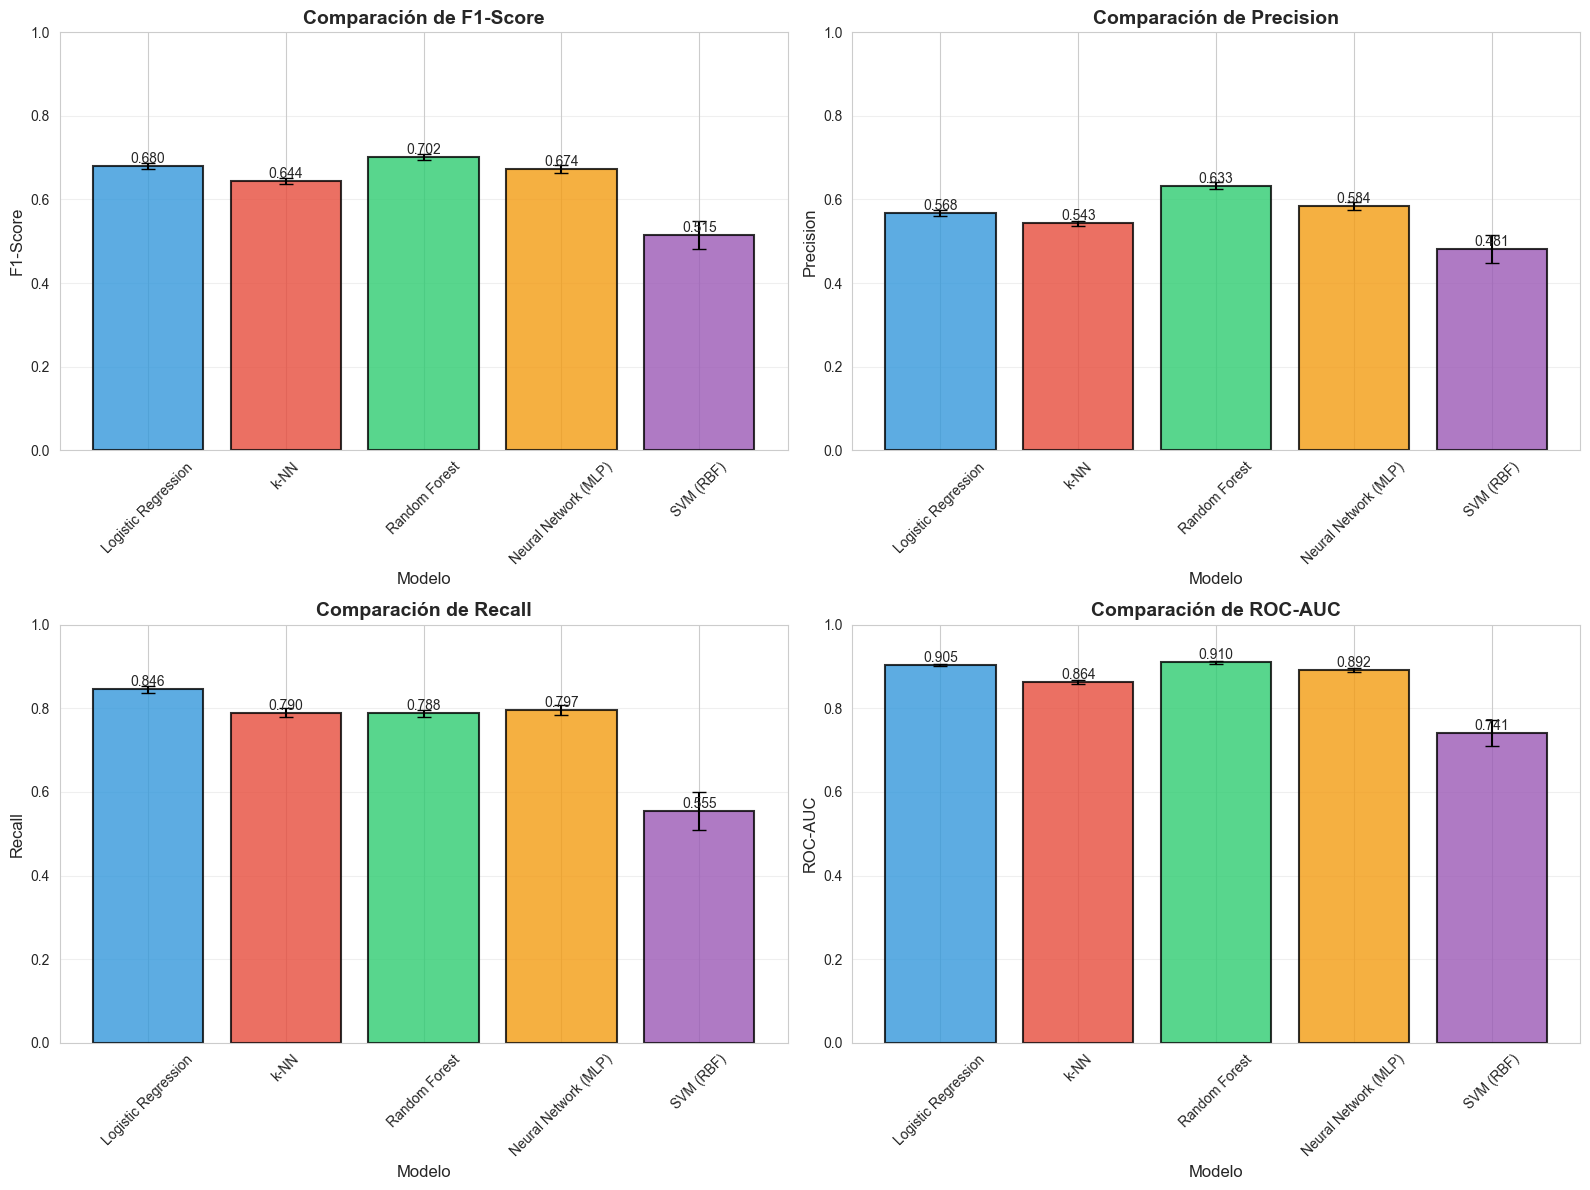

In [29]:
# Preparar datos para visualización
metrics = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC']
models = [r['model'] for r in all_results]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metric_keys = ['f1', 'precision', 'recall', 'roc_auc']

for idx, (metric, key) in enumerate(zip(metrics, metric_keys)):
    means = [np.mean(r[key]) for r in all_results]
    stds = [np.std(r[key]) for r in all_results]
    
    bars = axes[idx].bar(models, means, yerr=stds, capsize=5, 
                         color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'],
                         alpha=0.8, edgecolor='black', linewidth=1.5)
    
    axes[idx].set_title(f'Comparación de {metric}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_xlabel('Modelo', fontsize=12)
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Agregar valores sobre las barras
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{mean:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 20. Visualización: Curvas ROC

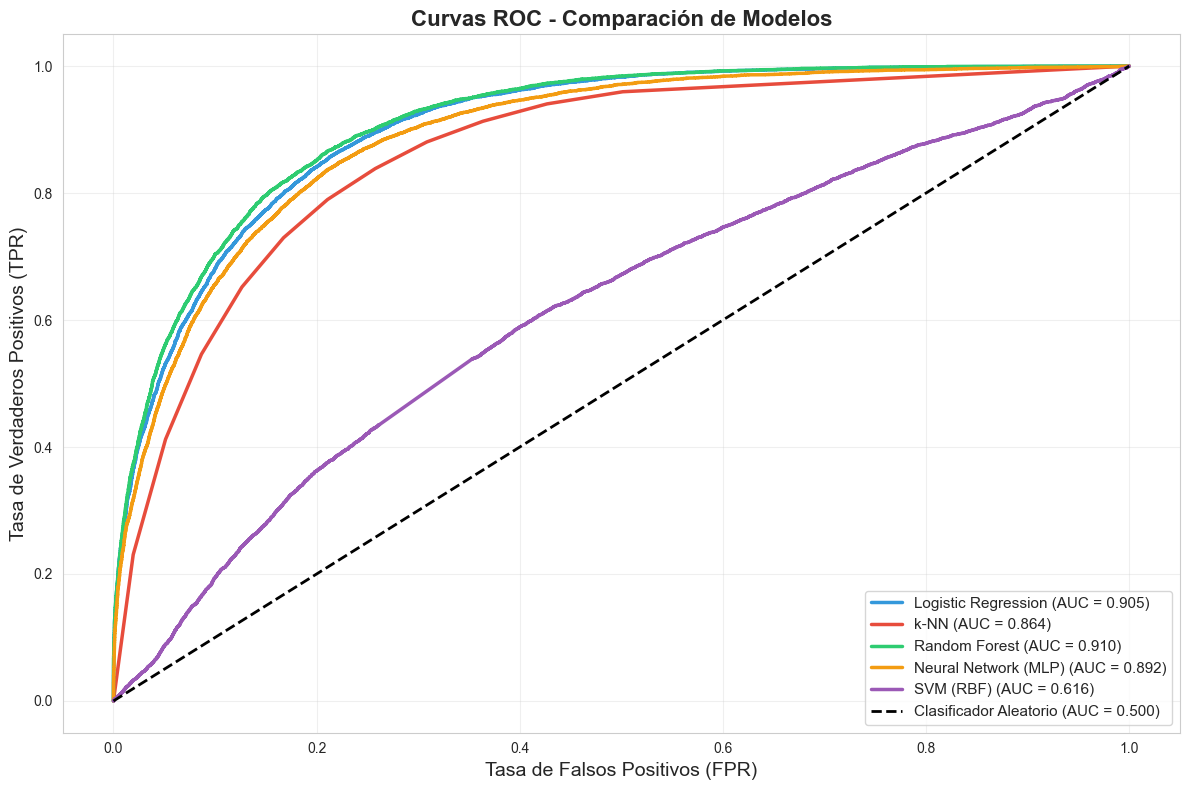

In [30]:
# Generar curvas ROC para todos los modelos
from sklearn.model_selection import cross_val_predict

plt.figure(figsize=(12, 8))

# Lista de modelos y sus nombres
models_list = [
    (grid_search_lr.best_estimator_, 'Logistic Regression', '#3498db'),
    (grid_search_knn.best_estimator_, 'k-NN', '#e74c3c'),
    (random_search_rf.best_estimator_, 'Random Forest', '#2ecc71'),
    (random_search_mlp.best_estimator_, 'Neural Network (MLP)', '#f39c12'),
    (random_search_svm.best_estimator_, 'SVM (RBF)', '#9b59b6')
]

for model, name, color in models_list:
    # Obtener probabilidades predichas mediante CV
    y_proba = cross_val_predict(model, X, y, cv=cv_strategy, method='predict_proba', n_jobs=-1)
    
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
    auc = roc_auc_score(y, y_proba[:, 1])
    
    # Graficar
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2.5, color=color)

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Clasificador Aleatorio (AUC = 0.500)')

plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 21. Visualización: Matrices de Confusión

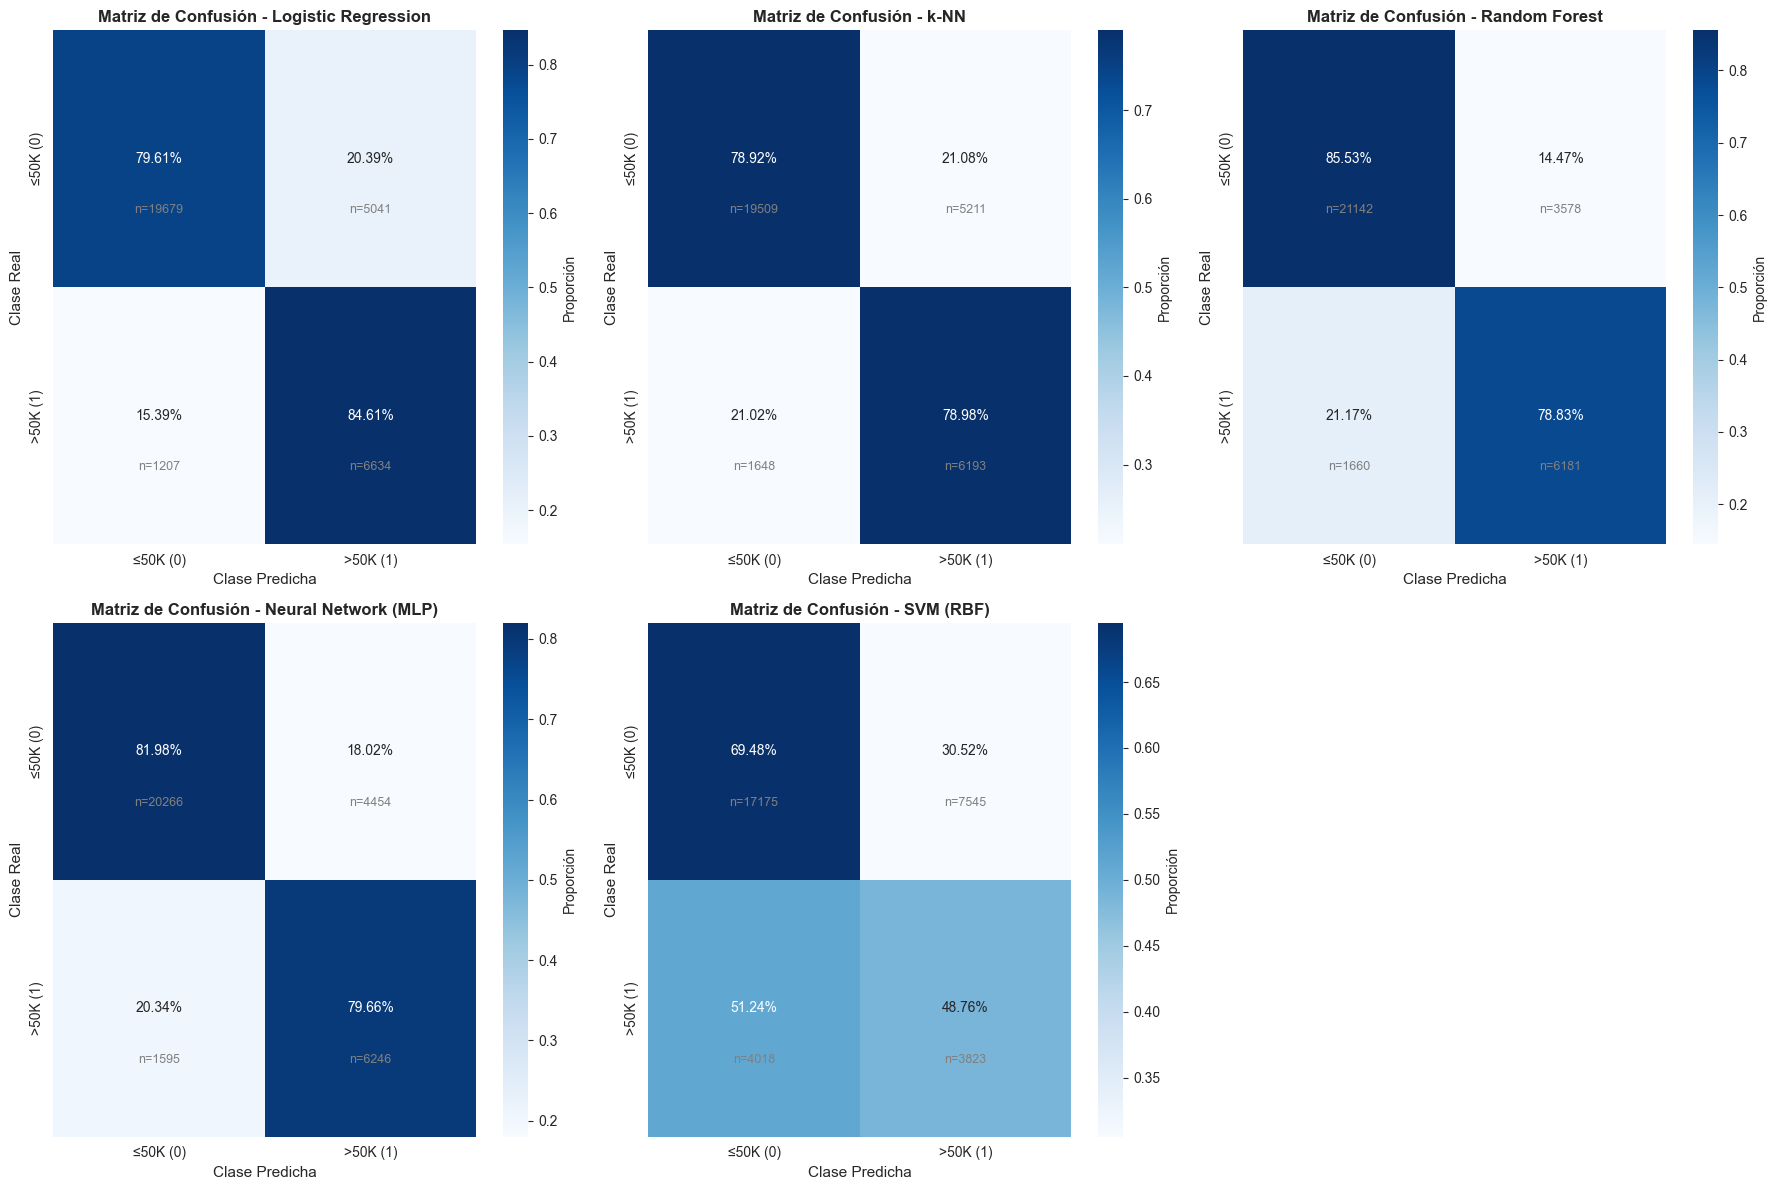

In [31]:
# Generar matrices de confusión para todos los modelos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model, name, _) in enumerate(models_list):
    # Obtener predicciones mediante CV
    y_pred = cross_val_predict(model, X, y, cv=cv_strategy, n_jobs=-1)
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y, y_pred)
    
    # Normalizar para mostrar porcentajes
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Crear heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                ax=axes[idx], cbar_kws={'label': 'Proporción'},
                xticklabels=['≤50K (0)', '>50K (1)'],
                yticklabels=['≤50K (0)', '>50K (1)'])
    
    axes[idx].set_title(f'Matriz de Confusión - {name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Clase Real', fontsize=11)
    axes[idx].set_xlabel('Clase Predicha', fontsize=11)
    
    # Agregar conteos totales en las celdas
    for i in range(2):
        for j in range(2):
            text = axes[idx].text(j + 0.5, i + 0.7, f'n={cm[i, j]}',
                                ha='center', va='center', fontsize=9, color='gray')

# Ocultar el último subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 22. Guardar Mejores Modelos

In [32]:
# Guardar los mejores modelos entrenados
import os

# Crear directorio para modelos si no existe
os.makedirs('modelos_entrenados', exist_ok=True)

# Guardar cada modelo
joblib.dump(grid_search_lr.best_estimator_, 'modelos_entrenados/logistic_regression.pkl')
joblib.dump(grid_search_knn.best_estimator_, 'modelos_entrenados/knn.pkl')
joblib.dump(random_search_rf.best_estimator_, 'modelos_entrenados/random_forest.pkl')
joblib.dump(random_search_mlp.best_estimator_, 'modelos_entrenados/neural_network.pkl')
joblib.dump(random_search_svm.best_estimator_, 'modelos_entrenados/svm.pkl')

print("Modelos guardados exitosamente en el directorio 'modelos_entrenados/':")
print("✓ logistic_regression.pkl")
print("✓ knn.pkl")
print("✓ random_forest.pkl")
print("✓ neural_network.pkl")
print("✓ svm.pkl")

Modelos guardados exitosamente en el directorio 'modelos_entrenados/':
✓ logistic_regression.pkl
✓ knn.pkl
✓ random_forest.pkl
✓ neural_network.pkl
✓ svm.pkl


## 23. Resumen Final de Hiperparámetros Óptimos

In [33]:
print("="*80)
print("RESUMEN DE HIPERPARÁMETROS ÓPTIMOS")
print("="*80)

print("\n1. Regresión Logística:")
print(f"   {grid_search_lr.best_params_}")

print("\n2. k-Nearest Neighbors:")
print(f"   {grid_search_knn.best_params_}")

print("\n3. Random Forest:")
print(f"   {random_search_rf.best_params_}")

print("\n4. Red Neuronal (MLP):")
print(f"   {random_search_mlp.best_params_}")

print("\n5. SVM (RBF):")
print(f"   {random_search_svm.best_params_}")

print("="*80)

RESUMEN DE HIPERPARÁMETROS ÓPTIMOS

1. Regresión Logística:
   {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

2. k-Nearest Neighbors:
   {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}

3. Random Forest:
   {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}

4. Red Neuronal (MLP):
   {'classifier__max_iter': 500, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (64, 32), 'classifier__alpha': 0.001, 'classifier__activation': 'relu'}

5. SVM (RBF):
   {'classifier__kernel': 'rbf', 'classifier__gamma': 0.01, 'classifier__C': 100}


## 24. Conclusiones del Análisis

In [34]:
# Identificar el mejor modelo según F1-Score
f1_means = [np.mean(r['f1']) for r in all_results]
best_idx = np.argmax(f1_means)
best_model = all_results[best_idx]

print("="*80)
print("CONCLUSIONES")
print("="*80)
print(f"\n✓ Mejor modelo según F1-Score: {best_model['model']}")
print(f"  - F1-Score: {np.mean(best_model['f1']):.4f} ± {np.std(best_model['f1']):.4f}")
print(f"  - ROC-AUC: {np.mean(best_model['roc_auc']):.4f} ± {np.std(best_model['roc_auc']):.4f}")
print(f"  - Precision: {np.mean(best_model['precision']):.4f} ± {np.std(best_model['precision']):.4f}")
print(f"  - Recall: {np.mean(best_model['recall']):.4f} ± {np.std(best_model['recall']):.4f}")

print("\n✓ Metodología aplicada:")
print("  - Validación cruzada estratificada (5-fold)")
print("  - SMOTE aplicado solo en conjunto de entrenamiento (evitando data leakage)")
print("  - Normalización dentro del pipeline de CV")
print("  - Búsqueda de hiperparámetros (Grid/Randomized Search)")
print("  - Métricas: Accuracy, Precision, Recall, F1-Score, ROC-AUC")

print("\n✓ Dataset:")
print(f"  - Total de muestras: {len(y)}")
print(f"  - Features después de encoding: {X.shape[1]}")
print(f"  - Ratio de desbalance original: {(y==0).sum()/(y==1).sum():.2f}:1")

print("\n" + "="*80)

CONCLUSIONES

✓ Mejor modelo según F1-Score: Random Forest
  - F1-Score: 0.7024 ± 0.0074
  - ROC-AUC: 0.9102 ± 0.0030
  - Precision: 0.6334 ± 0.0081
  - Recall: 0.7883 ± 0.0091

✓ Metodología aplicada:
  - Validación cruzada estratificada (5-fold)
  - SMOTE aplicado solo en conjunto de entrenamiento (evitando data leakage)
  - Normalización dentro del pipeline de CV
  - Búsqueda de hiperparámetros (Grid/Randomized Search)
  - Métricas: Accuracy, Precision, Recall, F1-Score, ROC-AUC

✓ Dataset:
  - Total de muestras: 32561
  - Features después de encoding: 97
  - Ratio de desbalance original: 3.15:1

